In [12]:
%reset -f

In [13]:
import torch
import os
from pyDOE import lhs
from utils import torchIWT
from torch.autograd import Variable
import numpy as np
import scipy.io as sio
import torch.nn as nn
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [14]:
seed = 2947
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [15]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)
    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [16]:
class Model:
    def __init__(self, net, epoch,
                 lb, ub,
                 x_bc, u_bc,
                 x, t,
                 x_f_loss_fun,
                 x_test_point, x_test_exact):
        self.net = net
        self.epoch = epoch
        self.lb = lb
        self.ub = ub

        self.x_bc = x_bc
        self.u_bc = u_bc

        self.x = x
        self.t = t

        self.x_f = None

        self.x_f_loss_fun = x_f_loss_fun
        self.x_test_point = x_test_point
        self.x_test_exact = x_test_exact

        self.sample_N = 2000
        self.sample_M = 1000

        self.x_f_N = None
        self.x_f_M = None

        self.x_bc_s = torch.tensor(0.).float().to(device)
        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_test_estimate_collect = []

        self.top1 = torch.inf

    def true_loss(self, loss_e, loss_bc):
        loss = torch.exp(-self.x_f_s.detach()) * loss_e \
                + torch.exp(-self.x_bc_s.detach()) * loss_bc
        return loss
    
    def likelihood_loss(self, loss_e, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
                + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss
    
    def evaluate(self):
        pred = self.net(self.x_test_point).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def random_sample(self, num):
        temp = torch.from_numpy(self.lb + (self.ub - self.lb) * lhs(2, num)).float().to(device)
        return temp

    def run(self, lr, wlr, j0, J_tmp, e_tmp):

        optim = torch.optim.Adam(self.net.parameters(), lr)
        optim_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s], lr=wlr)
        optim2 = torch.optim.LBFGS(self.net.parameters(), lr=1.0,
            max_iter=50000, max_eval=50000, history_size=50,
            tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        for i in range(self.epoch):
            u_bc_pred = self.net(self.x_bc)
            
            f_pred = self.x_f_loss_fun(self.x_f, self.net)

            loss_e = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)
            optim.zero_grad()

            loss = self.true_loss(loss_e, loss_bc)
            if ((i+1) % 2500) == 0 and (i != 0):
                self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, loss: {}'.format(i, loss.item()), end='\r')

            loss.backward()
            optim.step()            
            optim_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_bc)
            loss.backward()
            optim_weight.step()
        print("\nOPTIM1 DONE")


        closure_i = 0
        def closure():
            optim2.zero_grad()
            u_bc_pred = self.net(self.x_bc)
            x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
            f_pred = self.x_f_loss_fun(x_f, self.net)

            loss_e = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)
            loss = self.true_loss(loss_e, loss_bc)

            loss.backward()
            nonlocal closure_i
            closure_i += 1
            # if closure_i % 2500 == 0:
            #     self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, OPTIM2 LOSS:{}'.format(closure_i, loss.item()), end='\r')
            return loss
        
        optim2.step(closure)
        print("\nOPTIM2 DONE")
        error = self.evaluate()
        if error < self.top1:
            self.top1 = error
            torch.save(self.net.state_dict(), './best_model.pth')
        print('Test_L2error:', '{0:.2e}'.format(error))
        self.x_test_estimate_collect.append([error])
            
    def train(self, move_epoch, lr, wlr, j0, J, e):
        self.x_f_N = self.random_sample(self.sample_N)
        self.x_f_M = self.random_sample(self.sample_M)

        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        
        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_bc_s = torch.tensor(0.).float().to(device)

        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        
        self.run(lr[0], wlr, j0, J, e)

        for j in range(1, move_epoch):
            print("epoch: ", j)
            if j > 4:
                lr_tmp = lr[-1]
            else:
                lr_tmp = lr[j]
            self.run(lr_tmp, wlr, j0, J, e) 
    
    def move_point(self, j0, J_tmp, e_tmp):
        imgl = self.net(self.x_test_point).reshape(self.x.shape[0], self.t.shape[0])
        iwt = torchIWT(j0, J_tmp, e_tmp).to(device)

        _, idxs = iwt.get_Iwt2d(imgl, self.x, self.t)
        idxn = []
        for i in idxs:
            idxn = idxn + i
        idxn = torch.tensor(idxn).to(device).float()

        kde = gaussian_kde(idxn.cpu().T)
        expanded_idxns = kde.resample(self.sample_M).T
        expanded_idxns = torch.tensor(expanded_idxns).float().to(device)
        # k = torch.cat((idxn, expanded_idxns), dim=0)
        k = expanded_idxns

        k[:,0] = 2 * k[:, 0] / self.x.shape[0] - 1. # x
        k[:,1] = 2 * k[:, 1] / self.t.shape[0] - 1.  # t

        k2 = k[(k[:, 0] >= self.lb[1]) & (k[:, 0] <= self.ub[1]) & (k[:, 1] >= self.lb[0]) & (k[:, 1] < self.ub[0])]
        k = torch.unique(k2, dim=0)

        self.x_f_M = torch.zeros_like(k)
        self.x_f_M[:, 0] = k[:, 1]
        self.x_f_M[:, 1] = k[:, 0]

        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        
        print("\nnumber of moved point:{}".format(self.x_f_M.shape[0]))

In [17]:
k = 1
a1 = 1
a2 = 4

rc1 = 0.5
rc2 = 0.3
rc3 = -0.5
rc4 = -0.3

In [18]:
def exact_u(x):
    return np.sin(a1 * np.pi * x[:, [0]]) * np.sin(a2 * np.pi * x[:, [1]])

In [19]:
def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x)
    d = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)
    u_x1 = d[0][:, 0].unsqueeze(-1)
    u_x2 = d[0][:, 1].unsqueeze(-1)
    u_x1x1 = torch.autograd.grad(u_x1, x, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0][:, 0].unsqueeze(-1)
    u_x2x2 = torch.autograd.grad(u_x2, x, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0][:, 1].unsqueeze(-1)
    u_exact = torch.sin(a1 * torch.pi * x[:, [0]]) * torch.sin(a2 * torch.pi * x[:, [1]])
    f = -(a1 * torch.pi) ** 2 * u_exact - (a2 * torch.pi) ** 2 * u_exact + k ** 2 * u_exact - \
        (u_x1x1 + u_x2x2 + k ** 2 * u)
    return f

In [20]:
def get_helmholtz_data(exact_u):
    x = np.expand_dims(np.linspace(-1, 1, 256), axis=1)
    t = np.expand_dims(np.linspace(-1, 1, 256), axis=1)
    X, T = np.meshgrid(x, t)
    x_test_np = np.concatenate(
        (np.vstack(np.expand_dims(X, axis=2)), 
         np.vstack(np.expand_dims(T, axis=2))), axis=-1)
    usol = exact_u(x_test_np)
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().reshape(-1, 1).to(device)
    return x, t, x_test, x_test_exact

In [21]:
def get_pinn_input_data(Nbc, exact_u):
    x1_boundary_left = torch.cat((torch.full([Nbc, 1], -1), torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2), dim=1)
    x1_boundary_right = torch.cat((torch.full([Nbc, 1], 1), torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2), dim=1)
    x2_boundary_left = torch.cat((torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.full([Nbc, 1], -1)), dim=1)
    x2_boundary_right = torch.cat((torch.full([Nbc, 1], -1) + torch.rand([Nbc, 1]) * 2, torch.full([Nbc, 1], 1)), dim=1)
    x1_boundary_left_label = torch.from_numpy(exact_u(x1_boundary_left.numpy())).float()
    x1_boundary_right_label = torch.from_numpy(exact_u(x1_boundary_right.numpy())).float()
    x2_boundary_left_label = torch.from_numpy(exact_u(x2_boundary_left.numpy())).float()
    x2_boundary_right_label = torch.from_numpy(exact_u(x2_boundary_right.numpy())).float()
    x_bc = torch.cat((x1_boundary_left, x1_boundary_right, x2_boundary_left, x2_boundary_right), dim=0).to(device)
    u_bc = torch.cat((x1_boundary_left_label, x1_boundary_right_label, x2_boundary_left_label, x2_boundary_right_label), dim=0).to(device)
    return x_bc, u_bc

In [22]:
lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1.0])

layers = [2, 20, 20, 20, 20, 1]
epoch = 5000

net = Net(layers).to(device)

Nbc = 200
x_bc, u_bc = get_pinn_input_data(Nbc, exact_u)

x, t, x_test_point, x_test_exact = get_helmholtz_data(exact_u)

model = Model(net, epoch,
                lb, ub,
                x_bc, u_bc,
                x, t,
                x_f_loss_fun,
                x_test_point, x_test_exact)

lr = [0.001, 0.001, 0.0003, 0.0001, 0.00003]
wlr = 0.001



j0 = 0
J = 5
e = 0.01

model.train(move_epoch=10, lr=lr, wlr=wlr, j0=j0, J=J, e=e)  # 10

network train epoch: 2498, loss: 6.0266761779785165
number of moved point:774
network train epoch: 4998, loss: 1.6845771074295044
number of moved point:798
network train epoch: 4999, loss: 1.6844885349273682
OPTIM1 DONE
network train epoch: 14406, OPTIM2 LOSS:0.0038475973997265133
OPTIM2 DONE
Test_L2error: 1.68e-02
epoch:  1
network train epoch: 2498, loss: 0.0244297422468662265
number of moved point:801
network train epoch: 4998, loss: 0.110501334071159366
number of moved point:808
network train epoch: 4999, loss: 0.11040209233760834
OPTIM1 DONE
network train epoch: 5811, OPTIM2 LOSS:0.011863039806485176
OPTIM2 DONE
Test_L2error: 1.77e-03
epoch:  2
network train epoch: 2498, loss: 0.078152991831302644
number of moved point:836
network train epoch: 4998, loss: 0.16490359604358673
number of moved point:774
network train epoch: 4999, loss: 0.16499188542366028
OPTIM1 DONE
network train epoch: 1159, OPTIM2 LOSS:0.15328957140445714
OPTIM2 DONE
Test_L2error: 1.27e-03
epoch:  3
network train 

In [23]:
x_test_pred = net(x_test_point)

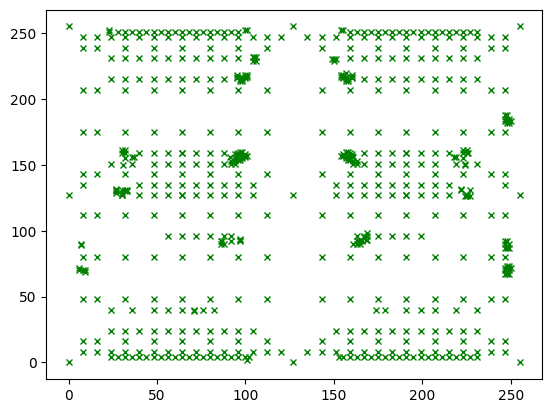

In [24]:
imgl = model.net(model.x_test_point).reshape(model.x.shape[0], model.t.shape[0])

iwt = torchIWT(j0, 7, 0.03).to(device)

_, idxs = iwt.get_Iwt2d(imgl, model.x, model.t)
idxn = []
for i in idxs:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()
plt.plot(idxn[:, [1]].cpu().numpy(), idxn[:, [0]].cpu().numpy(), 'gx', markersize=4)